This Notebook serves as a test lab for functions used in other notebooks. Therefore, it is a true mixed bag of functions haphazardly mixed in.

We are using a spotify API client made using a tutorial found here: [video](https://www.youtube.com/watch?v=xdq6Gz33khQ) [GitHub](https://github.com/codingforentrepreneurs/30-Days-of-Python/blob/master/tutorial-reference/Day%2019/notebooks/spotify_client.py)


In [ ]:
import base64
import datetime
from urllib.parse import urlencode

import requests

#Follows Spotify's "Implicit Grant" Authorization flow
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    authorization_url = "https://accounts.spotify.com/authorize"
    
    #external functions ("public")
    

    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')

    def get_playlist(self, _id):
        return self.get_resource(_id, resource_type='playlists')

    def get_playlist_tracks(self, _id):
        return self.get_resource(_id, resource_type='playlists', addendum='tracks')

    def get_track_features(self, _id):
        return self.get_resource(_id, resource_type='audio-features')

    def get_track_analysis(self, _id):
      return self.get_resource(_id, resource_type='audio-analysis') 

    def search(self, query=None, operator=None, operator_query=None, search_type='artist', limit=20 ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower(), "limit": str(limit)})
        return self.base_search(query_params)


    #internal functions ("private")


    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1', addendum=''):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}/{addendum}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    
    
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()

    #generic api request, accepts the full endpoint string

    def generic_get(self, endpoint):
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            if r.status_code == 429:
              print('Retry after ' + str(r.headers['Retry-After']) + ' seconds')
              raise Exception("You are requesting too much data, retry after " + str(r.headers['Retry-After']) + ' seconds')
            return {}
        return r.json()

    def generic_post(self, endpoint):
        headers = self.get_resource_header()
        r = requests.post(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            return {}
        return r.json()

    def generic_put(self, endpoint):
        headers = self.get_resource_header()
        r = requests.put(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)

    #new functions for user functions

    def get_current_user(self):
        endpoint = f"https://api.spotify.com/v1/me"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_current_user_recently_played(self):
        endpoint = f"https://api.spotify.com/v1/me/player/recently-played"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()

    def get_current_user_top(self, top_type='tracks', time_range='medium_term'):
        #endpoint = f"https://api.spotify.com/v1/me/top/{top_type}?limit=50&time_range{time_range}"
        endpoint = f"https://api.spotify.com/v1/me/top/{top_type}?time_range={time_range}&limit=50"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            print(r.status_code)
            return {}
        return r.json()

    def get_user(self, user):
        endpoint = f"https://api.spotify.com/v1/users/{user}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()


In [ ]:
import webbrowser
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Now, we pass our client ID and client secret from our Spotify Dev project into an instance of the spotify_client class. Paste in your own within the quotes. To get a your Spotify credentials, visit [here](https://developer.spotify.com/dashboard/login)

In [ ]:
client_id = ""
client_secret = ""

spotify =  SpotifyAPI(client_id, client_secret)

In [ ]:
scopes = ['user-read-email', 'user-read-private', 'playlist-read-collaborative', 'playlist-modify-public', 'playlist-read-private', 'playlist-modify-private', 'user-library-read', 'user-top-read', 'user-read-recently-played', 'user-modify-playback-state']
scopes_string = ' '.join(scopes)
authorization_url = "https://accounts.spotify.com/authorize"


params = {
            "client_id": client_id,
            "response_type": "token",
            "redirect_uri": "http://localhost:7777/callback",
            "scope": scopes_string
        } 

Follow the link generated to allow access to user data

In [ ]:
r = requests.get(authorization_url, params)
print("Successful if this is 200: " + str(r.status_code))
print("URL to paste in browser: " + str(r.url))

Successful if this is 200: 200
URL to paste in browser: https://accounts.spotify.com/login?continue=https%3A%2F%2Faccounts.spotify.com%2Fauthorize%3Fscope%3Duser-read-email%2Buser-read-private%2Bplaylist-read-collaborative%2Bplaylist-modify-public%2Bplaylist-read-private%2Bplaylist-modify-private%2Buser-library-read%2Buser-top-read%2Buser-read-recently-played%2Buser-modify-playback-state%26response_type%3Dtoken%26redirect_uri%3Dhttp%253A%252F%252Flocalhost%253A7777%252Fcallback%26client_id%3D5de0c3326eed4e17a4e2b226fc57a68f


Now paste the entire url you were sent to after allowing permissions between the quotes for "response ="

In [ ]:
#paste the entire url you are sent to here as a string(in quotes
response = ''
response_list_raw = response.split('&')

response_list = []
#hard coded extracting token and expires
for item in response_list_raw:
  response_list.append(item.split('='))

response_list

access_token = response_list[0][1]
expires_in = response_list[2][1]
print(access_token)

BQBSXLvkOYqwsTWCa0Lsprr5vOrmD34-IAwCPEb7xmDvWY1LeL531blzeEVjLg_hzIh9cAEY6yjVAQpzYBVNh6AHfOOlUUbSg-UA-VnQEGyEWhVLZIN51kiT32Ffgxb-oaZx9qZWbcCkvLoWZPhc_S2clNusTTvBWsJH1BnWavtqDnwojIbdl4sTKb7qaVR6Sb_1QDoCjOy-HltMQPOagvuxiCUYI_oCc_v02peQ-XNNu4zZJ3trbtej5LWXQzwFfec


In [ ]:
spotify_user = SpotifyAPI(client_id, client_secret)

spotify_user.access_token = access_token
spotify_user.access_token_expires = datetime.datetime.now() + datetime.timedelta(seconds=3600)
spotify_user.access_token_did_expire = False



In [ ]:
nu = spotify.search("Khalid", search_type='artist')

u = spotify_user.search("Khalid", search_type='artist')

print(spotify.access_token)
print(nu)
print(spotify_user.access_token)
print(u)

BQBw94tw1s4-GZheD7beV2afKc8Mfum4DX_UHY-j82nSmgq2nhs4Mtwt3P5VHc8p7pmX12e6EIIaHF0TK9Y
{'artists': {'href': 'https://api.spotify.com/v1/search?query=Khalid&type=artist&offset=0&limit=20', 'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6LuN9FCkKOj5PcnpouEgny'}, 'followers': {'href': None, 'total': 14116537}, 'genres': ['pop'], 'href': 'https://api.spotify.com/v1/artists/6LuN9FCkKOj5PcnpouEgny', 'id': '6LuN9FCkKOj5PcnpouEgny', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eb012b37d6dec8872b18524f78', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab67616100005174012b37d6dec8872b18524f78', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f178012b37d6dec8872b18524f78', 'width': 160}], 'name': 'Khalid', 'popularity': 91, 'type': 'artist', 'uri': 'spotify:artist:6LuN9FCkKOj5PcnpouEgny'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/7w9NGVft7cOEEa3CGGILZM'}, 'followers': {'href': None

End Initialization and test. Begin New stuff

In [ ]:
#seeing getting all possible recommendation genres for getting reccommnedations
all_recommend_genres = spotify.generic_get('https://api.spotify.com/v1/recommendations/available-genre-seeds')
all_recommend_genres

{'genres': ['acoustic',
  'afrobeat',
  'alt-rock',
  'alternative',
  'ambient',
  'anime',
  'black-metal',
  'bluegrass',
  'blues',
  'bossanova',
  'brazil',
  'breakbeat',
  'british',
  'cantopop',
  'chicago-house',
  'children',
  'chill',
  'classical',
  'club',
  'comedy',
  'country',
  'dance',
  'dancehall',
  'death-metal',
  'deep-house',
  'detroit-techno',
  'disco',
  'disney',
  'drum-and-bass',
  'dub',
  'dubstep',
  'edm',
  'electro',
  'electronic',
  'emo',
  'folk',
  'forro',
  'french',
  'funk',
  'garage',
  'german',
  'gospel',
  'goth',
  'grindcore',
  'groove',
  'grunge',
  'guitar',
  'happy',
  'hard-rock',
  'hardcore',
  'hardstyle',
  'heavy-metal',
  'hip-hop',
  'holidays',
  'honky-tonk',
  'house',
  'idm',
  'indian',
  'indie',
  'indie-pop',
  'industrial',
  'iranian',
  'j-dance',
  'j-idol',
  'j-pop',
  'j-rock',
  'jazz',
  'k-pop',
  'kids',
  'latin',
  'latino',
  'malay',
  'mandopop',
  'metal',
  'metal-misc',
  'metalcore',


Getting reccommended tracks based on a track passed to api

In [ ]:
recommendations = spotify.generic_get('https://api.spotify.com/v1/recommendations?seed_tracks=5qVJUvV1lyAwJnNKFMqurK')#('https://api.spotify.com/v1/recommendations?seed_genres='+genre+'&seed_tracks='+track+'&seed_artists='+artist) --currently appelsinskal


for track in recommendations['tracks']:
  print(track['name'] +' artist: '+ track['artists'][0]['name'])

Messing aroung with the player

# **PAUSE** 

In [ ]:
spotify_user.generic_put('https://api.spotify.com/v1/me/player/pause')

403


# **PLAY**

In [ ]:
spotify_user.generic_put('https://api.spotify.com/v1/me/player/play') 

#**VOLUME SWEEP UP**

In [ ]:
speed = 10

for volume in range(0, 101, speed):
  spotify_user.generic_put('https://api.spotify.com/v1/me/player/volume?volume_percent=' + str(volume)) 

#**VOLUME SWEEP DOWN**

In [ ]:
for volume in range(0, 101, speed):
  spotify_user.generic_put('https://api.spotify.com/v1/me/player/volume?volume_percent=' + str(100 - volume))

Getting similar artists

In [ ]:
artist = '0XDfNJsQy7B3q0GfsMHSkp'
similar_artists = spotify.generic_get(f'https://api.spotify.com/v1/artists/{artist}/related-artists')

In [ ]:
len(similar_artists)
len(similar_artists['artists'])

for artist in similar_artists['artists']:
  print(artist['name'])

ODZ
LBSB
Casper The Ghost
E.A. Lundquist
Snövit
Sebastian Stakset
Frej Larsson
Jireel
Lamix
Victor Leksell
Mwuana
Z.E
Dani M
Anis Don Demina
Ant Wan
Mares
Parham
Herbert Munkhammar
Erik Lundin
K27


Creating 1 user artist constellation, using json files generated in SpotifyUserPlayground or GetUserData

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kyle.sellers.json to kyle.sellers.json


In [ ]:
!ls

sample_data


In [ ]:
#choose next line to be same name as file uploaded (for example, john.smith.json)
user_file_name = ''

with open(user_file_name) as json_file:
    user_data = json.load(json_file)

print(user_data)

{'tracks_short_term': [{'album': {'album_type': 'SINGLE', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3IunaFjvNKj98JW89JYv9u'}, 'href': 'https://api.spotify.com/v1/artists/3IunaFjvNKj98JW89JYv9u', 'id': '3IunaFjvNKj98JW89JYv9u', 'name': 'The Japanese House', 'type': 'artist', 'uri': 'spotify:artist:3IunaFjvNKj98JW89JYv9u'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/0xeU1k5nVollgpFltxbMs1'}, 'href': 'https://api.spotify.com/v1/albums/0xeU1k5nVollgpFltxbMs1', 'i

In [ ]:
indices = {'resource_types':['tracks','artists'],'time_frames':['short_term','medium_term', 'long_term']}

user_artists_all = []

for time_frame in indices['time_frames']:
  artist_string = 'artists_' + time_frame

  user_artists_all += user_data[artist_string]

print(user_artists_all)

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3mIj9lX2MWuHmhNCA7LSCW'}, 'followers': {'href': None, 'total': 4088903}, 'genres': ['indie pop', 'modern alternative rock', 'modern rock', 'nu gaze', 'pop', 'rock'], 'href': 'https://api.spotify.com/v1/artists/3mIj9lX2MWuHmhNCA7LSCW', 'id': '3mIj9lX2MWuHmhNCA7LSCW', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/94dd2feca73bdfb7e1c12751b499ec0a46024866', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/05dcebda5c8594a51eeb4b3333572342152b6c38', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/1717dac024e71f64ec421a658c7a9769d41ce251', 'width': 160}], 'name': 'The 1975', 'popularity': 85, 'type': 'artist', 'uri': 'spotify:artist:3mIj9lX2MWuHmhNCA7LSCW'}, {'external_urls': {'spotify': 'https://open.spotify.com/artist/2GmsPqiejcB4bPdxJpkCh6'}, 'followers': {'href': None, 'total': 28726}, 'genres': ['danish pop'], 'href': 'https://api.spotify.com/v1/artists/2GmsPqiejcB4bPdxJpkCh6', 'id':

In [ ]:

user_artists_ids = []

top_all_time_artists = []
for artist in user_artists_all:
  user_artists_ids.append(artist['id'])

user_artists_ids = list(set(user_artists_ids))

for artist_id in user_artists_ids:
  for artist in user_artists_all:
    if artist_id == artist['id']:
      top_all_time_artists.append(artist)
      break
len(top_all_time_artists)

90

In [ ]:
# top_all_time_artists = user_data['artists_short_term']
# top_all_time_artists

In [ ]:

#block to assign artist
# top_all_time_artists = spotify_user.generic_get('https://api.spotify.com/v1/me/top/artists?time_range=long_term&limit=50')

# top_all_time_artists = top_all_time_artists['items']

In [ ]:
top_all_time_artists

artists_stripped = []

for artist in top_all_time_artists:
  artists_stripped.append({'name': artist['name'], 'id':artist['id']})


artists_stripped






[{'id': '4tZwfgrHOc3mvqYlEYSvVi', 'name': 'Daft Punk'},
 {'id': '536BYVgOnRky0xjsPT96zl', 'name': 'Two Door Cinema Club'},
 {'id': '1HQGhla3VNj1dBmKTtVT2t', 'name': 'Ookay'},
 {'id': '0XDfNJsQy7B3q0GfsMHSkp', 'name': 'Tjuvjakt'},
 {'id': '6kBDZFXuLrZgHnvmPu9NsG', 'name': 'Aphex Twin'},
 {'id': '2C2sVVXanbOpymYBMpsi89', 'name': 'The Cab'},
 {'id': '0szWPxzzE8DVEfXFRCLBUb', 'name': 'flor'},
 {'id': '27eEve8Mu7Zv8DGDIz4peE', 'name': 'Hugo Helmig'},
 {'id': '6FBDaR13swtiWwGhX1WQsP', 'name': 'blink-182'},
 {'id': '4vGrte8FDu062Ntj0RsPiZ', 'name': 'Polyphia'},
 {'id': '6zVFRTB0Y1whWyH7ZNmywf', 'name': 'Tash Sultana'},
 {'id': '5I0EPnV9gwrZYTbScjnaOk', 'name': 'Marcos Valle'},
 {'id': '00oL7zWxmWveTsKF7DnIRd', 'name': 'Kyle Dixon & Michael Stein'},
 {'id': '50JJSqHUf2RQ9xsHs0KMHg', 'name': 'Jon Bellion'},
 {'id': '4MCBfE4596Uoi2O4DtmEMz', 'name': 'Juice WRLD'},
 {'id': '46yZjVAVfu5XOYzOpBlfHW', 'name': 'UQiYO'},
 {'id': '6d4jrmreCmsenscuieJERc', 'name': 'The Band CAMINO'},
 {'id': '4LLpKhyESs

In [ ]:
for artist in artists_stripped:
  related_artist_ids = []
  similar_artists = spotify.generic_get('https://api.spotify.com/v1/artists/' + artist['id'] +'/related-artists')
  for similar_artist in similar_artists['artists']:
    related_artist_ids.append({'name':similar_artist['name'],'id':similar_artist['id']})
  artist['similar_artists'] = related_artist_ids

artists_stripped



[{'id': '4tZwfgrHOc3mvqYlEYSvVi',
  'name': 'Daft Punk',
  'similar_artists': [{'id': '1gR0gsQYfi6joyO1dlp76N', 'name': 'Justice'},
   {'id': '0UF7XLthtbSF2Eur7559oV', 'name': 'Kavinsky'},
   {'id': '0iui2Be5CP8EWxvHYsVspL', 'name': 'Breakbot'},
   {'id': '1GhPHrq36VKCY3ucVaZCfo', 'name': 'The Chemical Brothers'},
   {'id': '4sf3QZW8a3xZ14IGsOAzoy', 'name': 'Cassius'},
   {'id': '2fBURuq7FrlH6z5F92mpOl', 'name': 'Digitalism'},
   {'id': '54QMjE4toDfiCryzYWCpXX', 'name': 'Metronomy'},
   {'id': '3C8RpaI3Go0yFF9whvKoED', 'name': 'The Avalanches'},
   {'id': '57dN52uHvrHOxijzpIgu3E', 'name': 'Ratatat'},
   {'id': '37uLId6Z5ZXCx19vuruvv5', 'name': 'Hot Chip'},
   {'id': '2mV8aJphiSHYJf43DxL7Gt', 'name': 'Chromeo'},
   {'id': '67hb7towEyKvt5Z8Bx306c', 'name': 'Empire of the Sun'},
   {'id': '3hteYQFiMFbJY7wS0xDymP', 'name': 'Gesaffelstein'},
   {'id': '2CIMQHirSU0MQqyYHq0eOx', 'name': 'deadmau5'},
   {'id': '066X20Nz7iquqkkCW6Jxy6', 'name': 'LCD Soundsystem'},
   {'id': '1xU878Z1QtBldR7ru9o

In [ ]:
artist_map = []

for artist in artists_stripped:
  item = {'name': artist['name'],  'id': artist['id']}
  edges = []
  for similar_artist in artist['similar_artists']:
    for artist_2 in artists_stripped:
      # print(artist)
      # print(similar_artist)
      # print('----------------------------------------------')
      # print(f'{artist_id} ?= {sim_artist_id}')
      # print(artist['name'] + ' ?= ' + artist_2['name'] + '.' + similar_artist['name'])
      if artist_2['id'] == similar_artist['id']:
        edges.append({'name': artist_2['name'], 'id':artist_2['id']})
  item['edges'] = edges
  artist_map.append(item)

artist_map

[{'edges': [{'id': '2CIMQHirSU0MQqyYHq0eOx', 'name': 'deadmau5'}],
  'id': '4tZwfgrHOc3mvqYlEYSvVi',
  'name': 'Daft Punk'},
 {'edges': [], 'id': '536BYVgOnRky0xjsPT96zl', 'name': 'Two Door Cinema Club'},
 {'edges': [{'id': '0jNDKefhfSbLR9sFvcPLHo', 'name': 'San Holo'}],
  'id': '1HQGhla3VNj1dBmKTtVT2t',
  'name': 'Ookay'},
 {'edges': [], 'id': '0XDfNJsQy7B3q0GfsMHSkp', 'name': 'Tjuvjakt'},
 {'edges': [], 'id': '6kBDZFXuLrZgHnvmPu9NsG', 'name': 'Aphex Twin'},
 {'edges': [], 'id': '2C2sVVXanbOpymYBMpsi89', 'name': 'The Cab'},
 {'edges': [{'id': '6d4jrmreCmsenscuieJERc', 'name': 'The Band CAMINO'},
   {'id': '0m34JtkojthW5WYugFm0e3', 'name': 'Armors'}],
  'id': '0szWPxzzE8DVEfXFRCLBUb',
  'name': 'flor'},
 {'edges': [], 'id': '27eEve8Mu7Zv8DGDIz4peE', 'name': 'Hugo Helmig'},
 {'edges': [], 'id': '6FBDaR13swtiWwGhX1WQsP', 'name': 'blink-182'},
 {'edges': [{'id': '3Gs10XJ4S4OEFrMRqZJcic', 'name': 'Plini'}],
  'id': '4vGrte8FDu062Ntj0RsPiZ',
  'name': 'Polyphia'},
 {'edges': [], 'id': '6zVF

In [ ]:
import networkx as nx

G=nx.Graph()
G


In [ ]:
for artist in artist_map:
  G.add_node(artist['name'])

print(G.nodes())

print(len(G.nodes()))


['Daft Punk', 'Two Door Cinema Club', 'Ookay', 'Tjuvjakt', 'Aphex Twin', 'The Cab', 'flor', 'Hugo Helmig', 'blink-182', 'Polyphia', 'Tash Sultana', 'Marcos Valle', 'Kyle Dixon & Michael Stein', 'Jon Bellion', 'Juice WRLD', 'UQiYO', 'The Band CAMINO', 'Mac Miller', 'Tom Misch', 'San Holo', 'Porter Robinson', 'Khalid', 'Walk Off the Earth', 'Drake', 'Lil Wayne', 'The 1975', 'EDEN', 'Lip Candy', 'Playboi Carti', 'Olivver the Kid', 'Childish Gambino', 'Calvin Harris', 'Sawce', 'Cards', 'The Japanese House', 'XXXTENTACION', 'Mako', 'Moses: "Andreas"', 'Kanye West', 'Tritonal', 'Gill Chang', 'Covet', 'Flume', 'Oh Wonder', 'Jacob Collier', 'Martin Garrix', 'Amber Mark', 'Zedd', 'ICO', 'Citybois', 'Mumford & Sons', 'Louis The Child', 'Mondays', 'ASL', 'Xan Griffin', 'Deorro', 'Lil Uzi Vert', 'Matthew Chaim', 'Tame Impala', 'Clairo', 'Lauv', 'J Dilla', 'Mura Masa', 'Chon', 'Andrew Bayer', 'Kygo', 'Tyler, The Creator', 'Tycho', 'ODESZA', 'Cheat Codes', 'blackbear', 'Gryffin', 'ILLENIUM', 'Post M

In [ ]:
for artist in artist_map:
  for edge in artist['edges']:
    graph_edge = (artist['name'], edge['name'])
    G.add_edge(*graph_edge)

print(G.edges())
len(G.edges())

[('Daft Punk', 'deadmau5'), ('Ookay', 'San Holo'), ('flor', 'The Band CAMINO'), ('flor', 'Armors'), ('flor', 'The 1975'), ('flor', 'Olivver the Kid'), ('flor', 'The Japanese House'), ('flor', 'Oh Wonder'), ('Polyphia', 'Plini'), ('Jon Bellion', 'Marc E. Bassy'), ('Jon Bellion', 'EDEN'), ('Jon Bellion', 'blackbear'), ('Juice WRLD', 'Playboi Carti'), ('Juice WRLD', 'XXXTENTACION'), ('The Band CAMINO', 'The 1975'), ('The Band CAMINO', 'Olivver the Kid'), ('The Band CAMINO', 'The Japanese House'), ('Mac Miller', 'Childish Gambino'), ('Mac Miller', 'Tyler, The Creator'), ('San Holo', 'DROELOE'), ('San Holo', 'Louis The Child'), ('San Holo', 'ODESZA'), ('San Holo', 'ILLENIUM'), ('Khalid', 'Marc E. Bassy'), ('Drake', 'Lil Wayne'), ('The 1975', 'The Japanese House'), ('Playboi Carti', 'Lil Uzi Vert'), ('Olivver the Kid', 'Armors'), ('Childish Gambino', 'Tyler, The Creator'), ('Childish Gambino', 'Kanye West'), ('Calvin Harris', 'The Chainsmokers'), ('Calvin Harris', 'Cheat Codes'), ('Calvin Ha

74

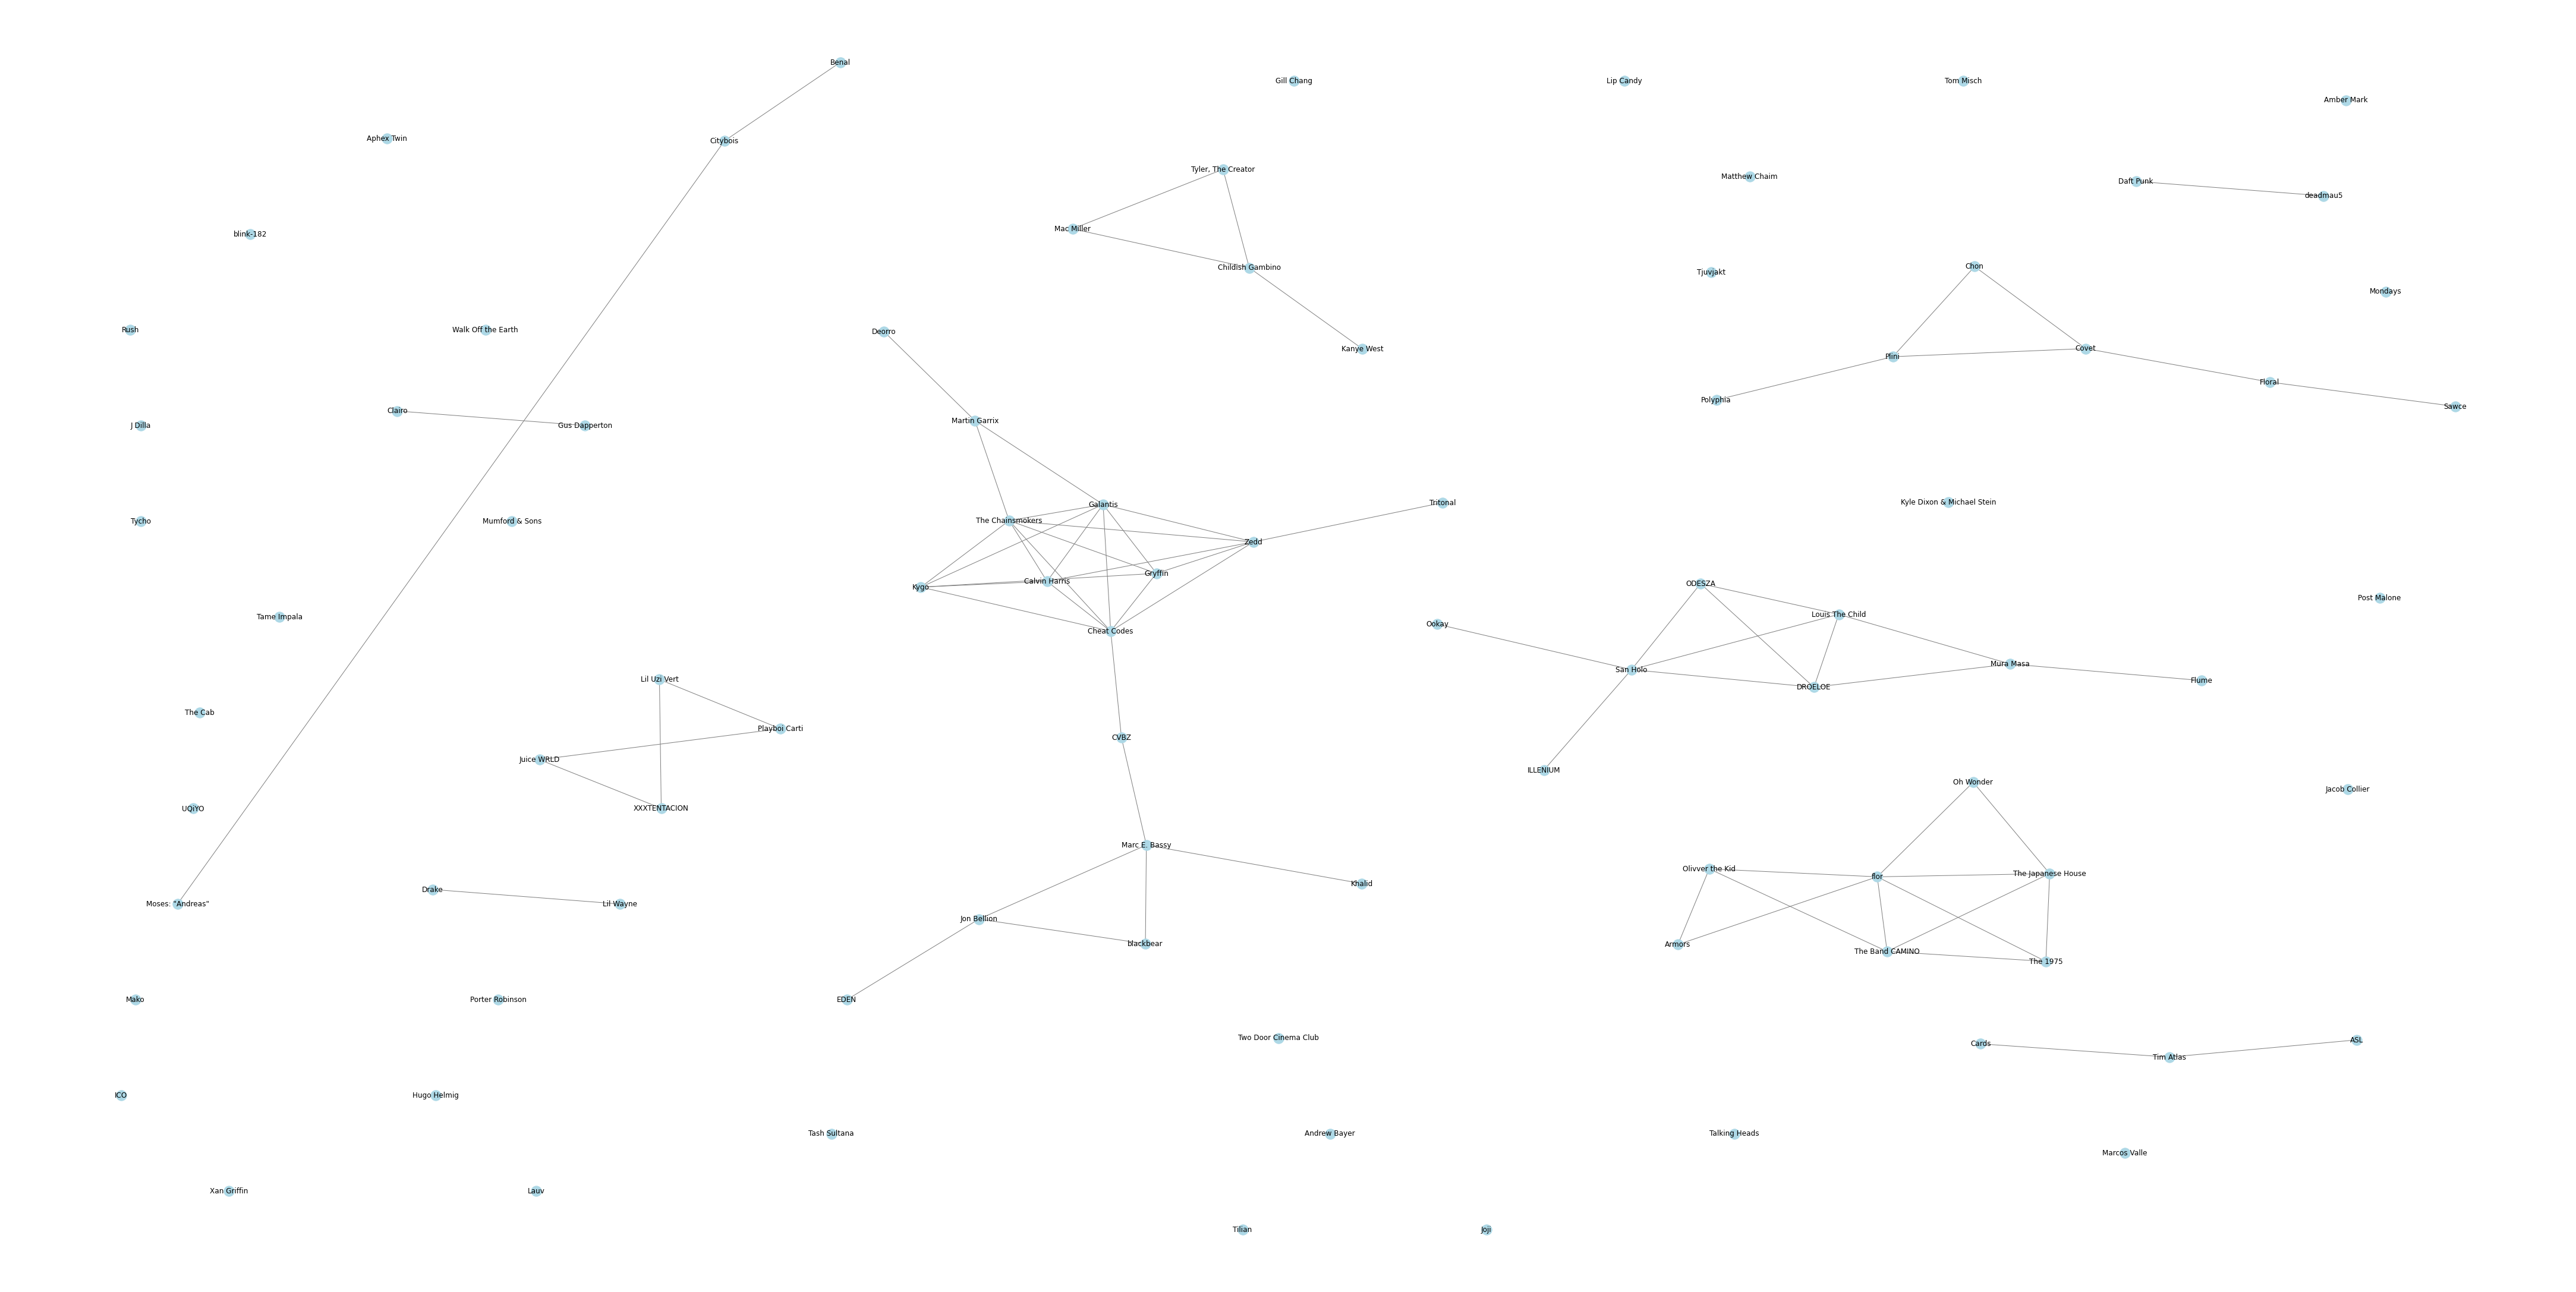

In [ ]:
# G = nx.Graph()

# G.add_node('a')
# G.add_node('b')
# edge= ('a', 'b')
# G.add_edge(*edge)

nx.draw(G,pos = nx.nx_pydot.graphviz_layout(G), with_labels = True,node_color='lightblue', edge_color='gray')

plt.rcParams["figure.figsize"] = (60,30)
# plt.savefig("avery_medium_term.png") # save as png
plt.show() # display

Lets make this thing go one layer deeper :O (Work in progress, was attempting to get related artists for each artist in the graph, and make the graph even larger

In [ ]:
# import time
# artists_level_2 = []

# count = 0
# try:
#   for artist in artists_stripped:
#     for similar_artist in artist['similar_artists']:
#       count = count + 1
#       print(count)
#       related_artist_ids_2 = []
#       similar_artists_2 = spotify.generic_get('https://api.spotify.com/v1/artists/' + similar_artist['id'] +'/related-artists')
      
    
#       for similar_artist_2 in similar_artists_2['artists']:
#         related_artist_ids_2.append({'name':similar_artist_2['name'],'id':similar_artist_2['id']})
#       similar_artist['similar_artists'] = related_artist_ids_2
  

# except Exception as e:
#   print(str(e))

# artists_level_2

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


[]

In [ ]:
# artist_map_2 = []

# count = 0
# for artist in artists_stripped:
#   for sim_artist in artist['similar_artists']:
#     for artist_2 in artists_stripped:
#       if artist['id'] == artist_2['id']:
#         break
#       if artist_2['id'] == sim_artist['id']:
#         break
#       for sim_artist_2 in artist_2['similar_artists']:
#         if artist['id'] == sim_artist_2['id']:
#           break
#         if sim_artist['id'] == sim_artist_2['id'] and artist['id'] != artist_2['id'] and not sim_artist['name'] in artists_stripped:
#           print(artist['name'] + ' -> ' + sim_artist['name'] + ' <- ' + artist_2['name'])
#           count += 1
#           print(count)
#           # print(count)

# # artist_map_2

In [25]:
rec_artists = {}

artists_stripped[0]

{'id': '4tZwfgrHOc3mvqYlEYSvVi',
 'name': 'Daft Punk',
 'similar_artists': [{'id': '1gR0gsQYfi6joyO1dlp76N', 'name': 'Justice'},
  {'id': '0UF7XLthtbSF2Eur7559oV', 'name': 'Kavinsky'},
  {'id': '0iui2Be5CP8EWxvHYsVspL', 'name': 'Breakbot'},
  {'id': '1GhPHrq36VKCY3ucVaZCfo', 'name': 'The Chemical Brothers'},
  {'id': '4sf3QZW8a3xZ14IGsOAzoy', 'name': 'Cassius'},
  {'id': '2fBURuq7FrlH6z5F92mpOl', 'name': 'Digitalism'},
  {'id': '54QMjE4toDfiCryzYWCpXX', 'name': 'Metronomy'},
  {'id': '3C8RpaI3Go0yFF9whvKoED', 'name': 'The Avalanches'},
  {'id': '57dN52uHvrHOxijzpIgu3E', 'name': 'Ratatat'},
  {'id': '37uLId6Z5ZXCx19vuruvv5', 'name': 'Hot Chip'},
  {'id': '2mV8aJphiSHYJf43DxL7Gt', 'name': 'Chromeo'},
  {'id': '67hb7towEyKvt5Z8Bx306c', 'name': 'Empire of the Sun'},
  {'id': '3hteYQFiMFbJY7wS0xDymP', 'name': 'Gesaffelstein'},
  {'id': '2CIMQHirSU0MQqyYHq0eOx', 'name': 'deadmau5'},
  {'id': '066X20Nz7iquqkkCW6Jxy6', 'name': 'LCD Soundsystem'},
  {'id': '1xU878Z1QtBldR7ru9owdU', 'name': 'Pho

In [28]:
url = 'https://accounts.spotify.com/authorize?client_id=5de0c3326eed4e17a4e2b226fc57a68f&response_type=code&response_uri=code&redirect_uri=http://localhost:8888/callback&code_challenge_method=S256&code_challenge=b_XeYv3R3_M'
r = requests.post(url)
print(r.status_code)



405


In [29]:
for key, val in r.headers.items():
  print(f'{key} : {val}')

r.reason

date : Sun, 25 Jul 2021 14:31:14 GMT
content-type : text/html; charset=utf-8
set-cookie : __Host-device_id=AQBuicnwGHSuM5ClAO9VjVe3f5ZyKiB-aAI_lxLzR7smEzU4lkaf0gyiMPzqgrpIzqEzPmZULk2ukK6lfhuMA6cJG6ETUCMAg28;Version=1;Path=/;Max-Age=2147483647;Secure;HttpOnly;SameSite=Lax
content-security-policy : default-src 'self'; script-src 'self' https://www.google-analytics.com https://ssl.google-analytics.com https://www.google.com https://www.gstatic.com/recaptcha/ https://www.google.com/recaptcha/ https://accounts.scdn.co; img-src 'self' https://i.imgur.com https://d2mv8tnci56s9d.cloudfront.net https://profile-images.scdn.co https://*.scdn.co https://graph.facebook.com https://fbcdn-profile-a.akamaihd.net https://*.fbcdn.net https://platform-lookaside.fbsbx.com https://www.google.com https://www.google-analytics.com https://stats.g.doubleclick.net data: https://accounts.scdn.co; font-src 'self' data: https://sp-bootstrap.global.ssl.fastly.net https://fonts.gstatic.com https://accounts.scdn.co; 

'Method Not Allowed'